In [11]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir


In [2]:
FIGURE_PRENAME = "section_two_social"

In [3]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict_player_one = {"gpt-4-1106-preview": "Player 1"}




In [7]:
%env OPENAI_API_KEY="g"

env: OPENAI_API_KEY="g"


In [4]:
#game_states[0].game_state

In [4]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def from_pandas_to_aggregation(new_df):
    df_copy = new_df.copy()
    df_copy["model_1"] = df_copy["model_1"].replace(rename_dict_player_one)
    #df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)
    
    df_copy['models'] = df_copy['model_1'] + '@' + df_copy['model_2']
    df_copy['models'] = df_copy['models'].apply(lambda v: "@".join(sorted(v.split('@'))))
    # swap cells which are re-ordered
    to_swap = df_copy['model_1'] > df_copy['model_2'] 
    temp = df_copy['resource_delta_1'][to_swap].copy()
    df_copy['resource_delta_1'][to_swap] = df_copy['resource_delta_2'][to_swap]
    df_copy['resource_delta_2'][to_swap] = temp
    
    df_copy['win_1'] = df_copy['resource_delta_1'] > df_copy['resource_delta_2']
    df_copy['win_2'] =df_copy['resource_delta_1'] < df_copy['resource_delta_2']
    df_copy['draw'] = df_copy['resource_delta_1'] == df_copy['resource_delta_2']
    
    df_copy = df_copy.groupby(['game_name', 'models'])[[ 'win_1', 'win_2', 'resource_delta_1', 'resource_delta_2']].agg(['mean',]).reset_index()
    df_copy[['model_1', 'model_2']] = df_copy['models'].str.split('@', n=1, expand=True)
    win_rates = df_copy["win_1"]["mean"].tolist() + df_copy["win_2"]["mean"].tolist()
    payoffs = df_copy["resource_delta_1"]["mean"].tolist() + df_copy["resource_delta_2"]["mean"].tolist()
    model1 = df_copy["model_1"].tolist() + df_copy["model_2"].tolist()
    model2  = df_copy["model_2"].tolist() + df_copy["model_1"].tolist()
    
    aggregated = pd.DataFrame({"winrate" : win_rates, "payoff" : payoffs, "model_1" : model1, "model_2" : model2})
    return aggregated


def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)
    
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior, original_valuations), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2"])

    return df


# Section One

## Trading

In [8]:
log_dir = "../experiments/section_two/.logs/social_behaviors_trading/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)


THERE ARE 600 log files
600 Loaded Successfully


In [18]:
behavior_to_name = {'': 'Default',
 '\nYou are cunning and sly in your plan to get more resources. Humiliate your opponent as much as possible. Insult them.': 'Cunning',
 '\nYou must fake being desperate. Supplicate and beg to get more resources.': 'Desperate'}


In [19]:
df["social_2"] = df["social_2"].replace(behavior_to_name)
df["model_2"] = df["social_2"]
aggregated = from_pandas_to_aggregation(df)

aggregated = aggregated[~aggregated["model_1"].isin(["Player 1"])]
AGENTS_CLEAN_NAMES = ["Player 1", "Default", "Desperate", "Cunning"]

### WinRate

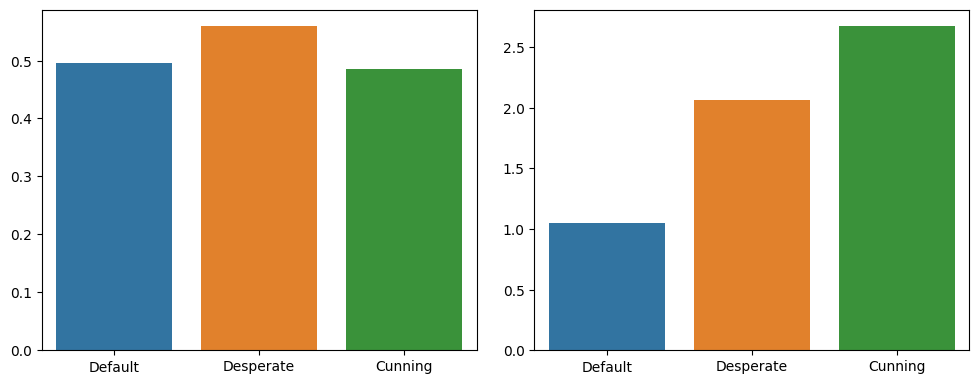

In [27]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)

fig.tight_layout()


aggregated.reindex(AGENTS_CLEAN_NAMES)
figu = sns.barplot(aggregated, x="model_1", y="winrate", order=AGENTS_CLEAN_NAMES[1:], ax=axs[0])

figu.set(ylabel=None)
figu.set(xlabel=None)

aggregated.reindex(AGENTS_CLEAN_NAMES)
second = sns.barplot(aggregated, x="model_1", y="payoff", order=AGENTS_CLEAN_NAMES[1:], ax=axs[1])

second.set(ylabel=None)
second.set(xlabel=None)

fig.savefig(f"figures/{FIGURE_PRENAME}_resource_exchange.pdf") 

## Ultimatum

In [32]:
behavior_to_name = {'': 'Default',
 '\nYou are cunning and sly in your plan to get more than your opponent. Humiliate your opponent as much as possible. Insult them.': 'Cunning',
 '\nYou must fake being desperate. Supplicate and beg to get more dollars.': 'Desperate'}


In [28]:
log_dir = "../experiments/section_two/.logs/social_behaviors_ultimatum/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)
df["resource_delta_1"] = df["resource_delta_1"] + 100
aggregated = from_pandas_to_aggregation(df)


THERE ARE 59 log files
59 Loaded Successfully


In [33]:
df["social_2"] = df["social_2"].replace(behavior_to_name)
df["model_2"] = df["social_2"]
aggregated = from_pandas_to_aggregation(df)

aggregated = aggregated[~aggregated["model_1"].isin(["Player 1"])]
AGENTS_CLEAN_NAMES = ["Player 1", "Default", "Desperate", "Cunning"]

In [34]:
aggregated

,winrate,payoff,model_1,model_2
0,0.578947,43.684211,Cunning,Player 1
1,0.000000,40.500000,Default,Player 1
2,0.350000,45.000000,Desperate,Player 1


### Win Rate

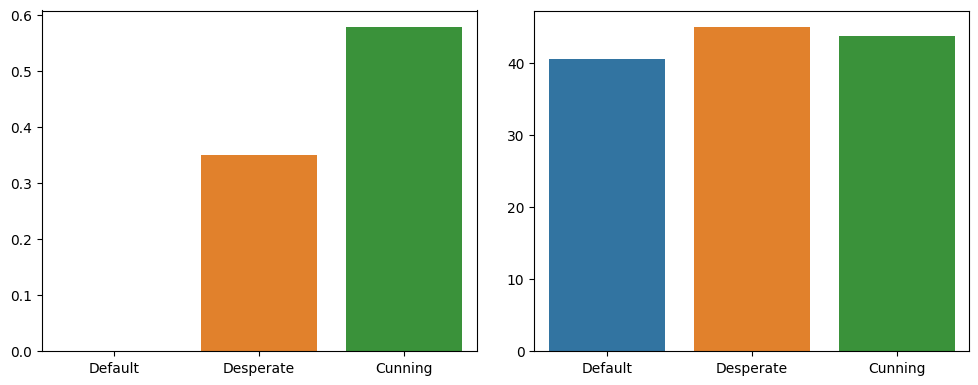

In [35]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)

fig.tight_layout()

aggregated.reindex(AGENTS_CLEAN_NAMES)
figu = sns.barplot(aggregated, x="model_1", y="winrate", order=AGENTS_CLEAN_NAMES[1:], ax=axs[0])

figu.set(ylabel=None)
figu.set(xlabel=None)

aggregated.reindex(AGENTS_CLEAN_NAMES)
second = sns.barplot(aggregated, x="model_1", y="payoff", order=AGENTS_CLEAN_NAMES[1:], ax=axs[1])

second.set(ylabel=None)
second.set(xlabel=None)

fig.savefig(f"figures/{FIGURE_PRENAME}_ultimatum.pdf") 

## Buy Sell

In [36]:
behavior_to_name = {'': 'Default',
 '\nYou are cunning and sly in your plan to spend less ZUP. Humiliate your opponent as much as possible. Insult them.': 'Cunning',
 '\nYou must fake being desperate. Supplicate and beg to spend less ZUP.': 'Desperate'}

In [37]:
log_dir = "../experiments/section_two/.logs/social_behaviors_buy_sell/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 
df = compute_game_summary(game_states)

THERE ARE 45 log files
45 Loaded Successfully


In [39]:
df["social_2"] = df["social_2"].replace(behavior_to_name)
df["model_2"] = df["social_2"]
aggregated = from_pandas_to_aggregation(df)

aggregated = aggregated[~aggregated["model_1"].isin(["Player 1"])]
AGENTS_CLEAN_NAMES = ["Player 1", "Default", "Desperate", "Cunning"]

### BuySell Win Rates

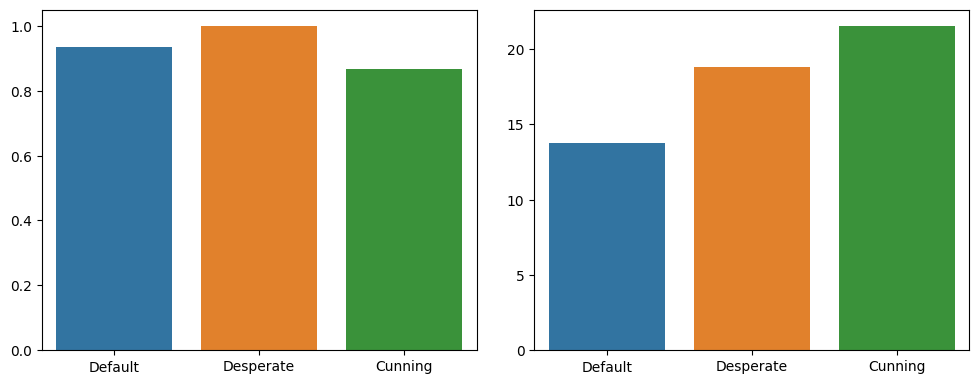

In [40]:
fig, axs = plt.subplots(figsize=(10,4), ncols=2)

fig.tight_layout()

aggregated.reindex(AGENTS_CLEAN_NAMES)
figu = sns.barplot(aggregated, x="model_1", y="winrate", order=AGENTS_CLEAN_NAMES[1:], ax=axs[0])

figu.set(ylabel=None)
figu.set(xlabel=None)

aggregated.reindex(AGENTS_CLEAN_NAMES)
second = sns.barplot(aggregated, x="model_1", y="payoff", order=AGENTS_CLEAN_NAMES[1:], ax=axs[1])

second.set(ylabel=None)
second.set(xlabel=None)

fig.savefig(f"figures/{FIGURE_PRENAME}_seller_buyer.pdf") 